# Проверка гипотез по увеличению выручки интернет-магазина - A/B тестирование

Я — аналитик крупного интернет-магазина. Вместе с отделом маркетинга я подготовилю список гипотез для увеличения выручки.

В данном проекте мы будем:

Приоритизировать гипотезы;

Запустим A/B-тест;

Проанализируем результаты;

Table of Contents

## Обзор данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import math
import warnings

warnings.filterwarnings("ignore")

In [2]:
hypothesis = pd.read_csv("/datasets/hypothesis.csv")
orders = pd.read_csv("/datasets/orders.csv")
visitors = pd.read_csv("/datasets/visitors.csv")

### Таблица Hypothesis

В таблице 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами: 

Hypothesis — краткое описание гипотезы;

Reach — охват пользователей по 10-балльной шкале;

Impact — влияние на пользователей по 10-балльной шкале;

Confidence — уверенность в гипотезе по 10-балльной шкале;

Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

In [3]:
# посмотрим на содержание таблицы
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


### Таблица Orders

transactionId — идентификатор заказа;

visitorId — идентификатор пользователя, совершившего заказ;

date — дата, когда был совершён заказ;

revenue — выручка заказа;

group — группа A/B-теста, в которую попал заказ.

In [4]:
# проверим таблицу на дубликаты, пропуски и заголовки:
tabs = [orders]
for tab in tabs:
    tab.info()
    print('')
    print('названия столбцев', tab.columns)
    print('')
    print('размер таблицы:', tab.shape)
    print('')
    print('количество пропусков:', '\n', tab.isna().sum())
    print('')
    print('количество явных дубликатов:', tab.duplicated().sum())
    print('')
    display(tab.head(3))
    print('')
    print('--------------------------------------------------')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB

названия столбцев Index(['transactionId', 'visitorId', 'date', 'revenue', 'group'], dtype='object')

размер таблицы: (1197, 5)

количество пропусков: 
 transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

количество явных дубликатов: 0



,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A



--------------------------------------------------


### Таблица Visitors

date — дата;

group — группа A/B-теста;

visitors — количество пользователей в указанную дату в указанной группе A/B-теста

In [5]:
# проверим таблицу на дубликаты, пропуски и заголовки:
tabs = [visitors]
for tab in tabs:
    tab.info()
    print('')
    print('названия столбцев', tab.columns)
    print('')
    print('размер таблицы:', tab.shape)
    print('')
    print('количество пропусков:', '\n', tab.isna().sum())
    print('')
    print('количество явных дубликатов:', tab.duplicated().sum())
    print('')
    display(tab.head(3))
    print('')
    print('--------------------------------------------------')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB

названия столбцев Index(['date', 'group', 'visitors'], dtype='object')

размер таблицы: (62, 3)

количество пропусков: 
 date        0
group       0
visitors    0
dtype: int64

количество явных дубликатов: 0



,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507



--------------------------------------------------


### Вывод
Данные без пропусков и дубликатов, с ними уже можно работать, но сначала приведем название столбцев к общепринятому виду и изменим тип данных в столбцах, содержащие временные данные

## Предобработка данных

In [6]:
# Приведем столбцы в нужный вид:
hypothesis.columns = hypothesis.columns.str.lower()
orders = orders.rename(columns={'transactionId':'transaction_id',
                                'visitorId':'visitor_id'})
hypothesis.head(1)

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6


In [7]:
orders.head(1)

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B


In [8]:
# преобразуем столбцы в datetime
visitors['date'] = pd.to_datetime(visitors['date'], format='%Y-%m-%d')
orders['date'] = pd.to_datetime(orders['date'], format='%Y-%m-%d')

visitors.info()
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


## Приоритизация гипотез

### Зачем и как приоритизировать гипотезы

Проверка гипотез чаще всего стоит дорого, а ресурсов не хватает. Придётся выбрать, что будем тестировать, а чему скажем «нет». Чтобы максимизировать ожидаемое улучшение ключевых метрик бизнеса, сформулированные гипотезы приоритизируют.

Рассмотрим методы упорядочивания экспериментов ICE и RICE:

ICE (от англ. impact, confidence, effort / ease «влияние, уверенность, усилия / простота») — один из самых популярных способов приоритизации задач: 

ICE SCORE = 'impact' * 'confidence' * 'ease' или ICE SCORE = ('impact' * 'confidence')/ 'efforts'

У этого метода есть модификация RICE (R от англ. reach, «охват»):

RICE SCORE = ('impact' * 'confidence' * 'reach') / 'efforts'

Фреймворк RICE состоит из четырёх компонент:

Reach — скольких пользователей затронет изменение, которое вы хотите внести;

Impact — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;

Confidence — насколько вы уверены, что это изменение повлияет на пользователей именно так;

Efforts — сколько стоит протестировать эту гипотезу.

Параметры фреймворков ICE и RICE оценивают в удобных шкалах: например, от 0 до 10 или в числах ряда Фибоначчи.

### Расчитаем ICE, RICE

In [9]:
# Подсчет "рейтинга" гипотез ICE
hypothesis['ice_score'] = ((hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']).round(2)
# Подсчет "рейтинга" гипотез RICE
hypothesis['rice_score'] = ((hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']).round(2)
#сортировка по ICE
display(hypothesis.sort_values(by = 'ice_score', ascending = False))

,hypothesis,reach,impact,confidence,efforts,ice_score,rice_score
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.20,16.2
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.33,40.0
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.20,112.0
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.00,40.0
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.00,56.0
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.33,4.0
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.12,9.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.00,3.0


In [10]:
#сортировка по RICE
display(hypothesis.sort_values(by = 'rice_score', ascending = False))

,hypothesis,reach,impact,confidence,efforts,ice_score,rice_score
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.20,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.33,40.0
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.00,3.0


### Вывод
При сортировке таблицы по ICE, на первое место выходит гипотеза №8. А при сортировке таблицы по RICE, на первое место выходит гипотеза №7. 

Отличие в том, что фреймворк RICE в отличие от ICE учитывает охват пользователей. Гипотеза № 7 имеет 10 баллов из 10 по графе "reach" - охват пользователей. Наименее приоритетной при использовании обоих фреймворков является гипотеза № 4.


## Анализ A/B-теста
A/B-тесты проводят, чтобы точно измерить эффект от внедрения изменения.

### Объединение таблиц orders и visitors

In [11]:
test_res = orders.merge(visitors, on=['date','group'])
test_res

,transaction_id,visitor_id,date,revenue,group,visitors
0,3667963787,3312258926,2019-08-15,1650,B,544
1,2804400009,3642806036,2019-08-15,730,B,544
2,3797467345,1196621759,2019-08-15,9759,B,544
3,2282983706,2322279887,2019-08-15,2308,B,544
4,182168103,935554773,2019-08-15,2210,B,544
...,...,...,...,...,...,...
1192,2274188238,132143192,2019-08-14,750,A,735
1193,1692103379,1022829655,2019-08-14,112,A,735
1194,2203539145,370388673,2019-08-14,3190,A,735
1195,1807773912,573423106,2019-08-14,10550,A,735


### Обработка данных по пользователям

Попавший в одну из групп посетитель остаётся в этой группе до конца теста. Если пользователь видит разные версии исследуемой страницы в ходе одного исследования, неизвестно, какая именно повлияла на его решения. Значит, и результаты такого теста нельзя интерпретировать однозначно.

In [12]:
# Найдем количество пользователей, которые попали одновременно в обе группы:
users_A = test_res.query('group == "A"')['visitor_id'].unique()
users_B = test_res.query('group == "B"')['visitor_id'].unique()
users_AB = list(set(users_A).intersection(users_B))
len(users_AB)

58

In [13]:
# удалим повторяющихся пользователей
test_res = test_res[~test_res['visitor_id'].isin(users_AB)]

In [14]:
# удалим повторяющихся пользователей и из таблицы orders
orders = orders[~orders['visitor_id'].isin(users_AB)]

In [15]:
# Найдем кол-во уникальных пользователей в каждой группе:
un_p_a = test_res.query('group == "A"')['visitor_id'].nunique()
print('Количество пользовательлей группы А:', un_p_a)
un_p_b = test_res.query('group == "B"')['visitor_id'].nunique()
print('Количество пользовательлей группы Б:', un_p_b)

Количество пользовательлей группы А: 445
Количество пользовательлей группы Б: 528


In [16]:
# посчитаем разницу пользователей в процентном соотношении:
AB_difference = un_p_a/ un_p_b 
print('Разница между размерами группы в процентном соотношении:{:.2%}'.format(AB_difference - 1))

Разница между размерами группы в процентном соотношении:-15.72%


Распределение пользователей в группы не равномерное. В группе А на 15,7% меньше пользователей, чем в группе Б. Диcбаланс групп может привести к неверным выводам. Следует учесть это при анализе данных.

In [17]:
# сгруппируем данные по дате и тестовой группе
test_res_agg = (test_res.groupby(['group','date'], as_index=False)
                        .agg({'visitor_id':'nunique',
                              'transaction_id':'nunique',
                              'revenue':'sum',
                              'visitors':'max'})
                      )
test_res_agg = test_res_agg.rename(columns={'visitor_id':'payers','transaction_id':'orders'})
test_res_agg['avg_check'] = (test_res_agg['revenue'] / test_res_agg['orders']).round(2)
test_res_agg['conversion'] = test_res_agg['orders'] / test_res_agg['visitors']

test_res_agg_A = test_res_agg.query('group =="A"')
test_res_agg_B = test_res_agg.query('group =="B"').reset_index(drop=True)

In [18]:
# Для каждой группы рассчитаем кумулятивные метрики
test_res_agg_A['cum_revenue'] = test_res_agg_A['revenue'].cumsum(axis=0)
test_res_agg_A['cum_orders'] = test_res_agg_A['orders'].cumsum(axis=0)
test_res_agg_A['cum_visitors'] = test_res_agg_A['visitors'].cumsum(axis=0)

test_res_agg_B['cum_revenue'] = test_res_agg_B['revenue'].cumsum(axis=0)
test_res_agg_B['cum_orders'] = test_res_agg_B['orders'].cumsum(axis=0)
test_res_agg_B['cum_visitors'] = test_res_agg_B['visitors'].cumsum(axis=0)

### График кумулятивной выручки по группам

Text(0.5, 1.0, 'Выручка по группам')

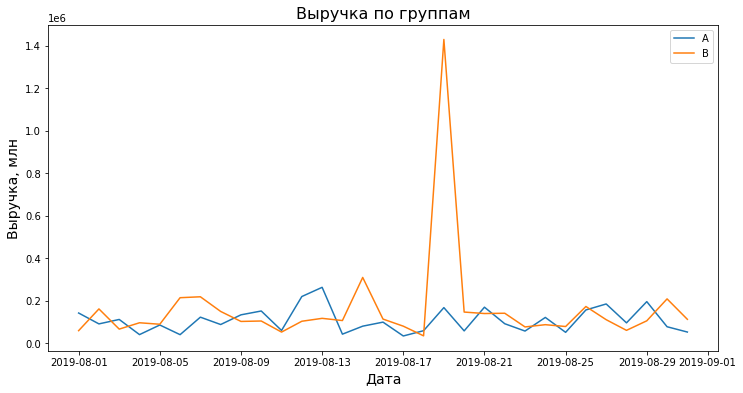

In [19]:
# построим простой график выручки для каждой группы
plt.figure(figsize=(12,6))
sns.lineplot(data=test_res_agg_A, x='date', y='revenue', label='A')
sns.lineplot(data=test_res_agg_B, x='date', y='revenue', label='B')
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Выручка, млн', fontsize=14)
plt.title('Выручка по группам', fontsize=16)

Покачто график нам показывает аномальный всплеск группы Б 19 августа.
Поскольку в группе Б пользователей больше, поробуем учесть эту разницу в анализе.

Text(0.5, 1.0, 'Кумулятивная выручка по группам')

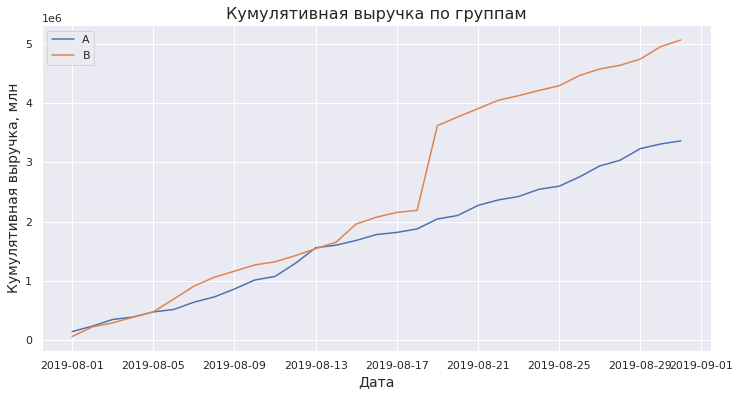

In [20]:
#  график кумулятивной выручки по группам
sns.set_theme()
plt.figure(figsize=(12,6))


revenue_B_adjusted = test_res_agg_B['cum_revenue'] / AB_difference

sns.lineplot(data=test_res_agg_A, x='date', y='cum_revenue', label='A')
sns.lineplot(data=test_res_agg_B, x='date', y='cum_revenue', label='B')


plt.xlabel('Дата', fontsize=14)
plt.ylabel('Кумулятивная выручка, млн', fontsize=14)
plt.title('Кумулятивная выручка по группам', fontsize=16)


Выручка равномерно растет на протяжении всего отрезка времени. Выручка группы Б все время чуть больше выручки группы А 

В группе Б выражен резкий всплеск, это может быть связано с большим выбросом 19 августа.Это может быть связано с появлением очень дорогого заказа, или с резким увеличением их числа. Из-за этого трудно напрямую сравнить две группы.

### График кумулятивного среднего чека по группам

Text(0.5, 1.0, 'Кумулятивный средний чек по группам')

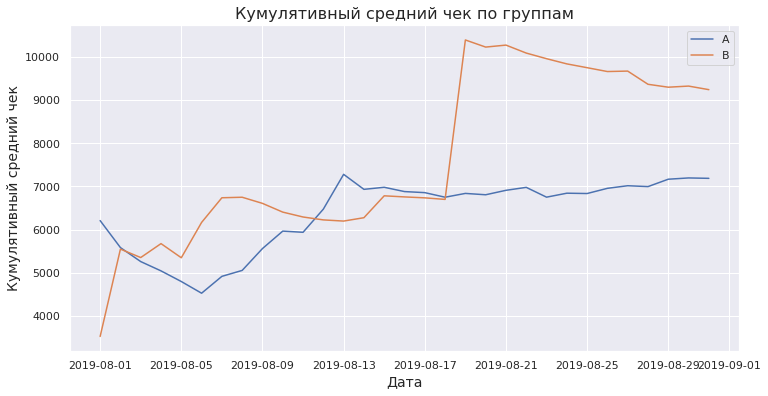

In [21]:
# Рассчитаем средний чек для групп, разделив кумулятивную выручку на кумулятивное число заказов:
test_res_agg_A['cum_avg_check'] = test_res_agg_A['cum_revenue'] / test_res_agg_A['cum_orders']
test_res_agg_B['cum_avg_check'] = test_res_agg_B['cum_revenue'] / test_res_agg_B['cum_orders']


plt.figure(figsize=(12,6))
sns.lineplot(data=test_res_agg_A, x='date', y='cum_avg_check', label='A')
sns.lineplot(data=test_res_agg_B, x='date', y='cum_avg_check', label='B')

plt.xlabel('Дата', fontsize=14)
plt.ylabel('Кумулятивный средний чек', fontsize=14)
plt.title('Кумулятивный средний чек по группам', fontsize=16)

Видим резкий скачоксреднего чека группы Б, после чего идет плавное снижение, а средний чек группы А равномерно увеличивается, при этом почти всегда меньше группы Б

Посмотрим на график без выброса:

Text(0.5, 1.0, 'Кумулятивный средний чек по группам')

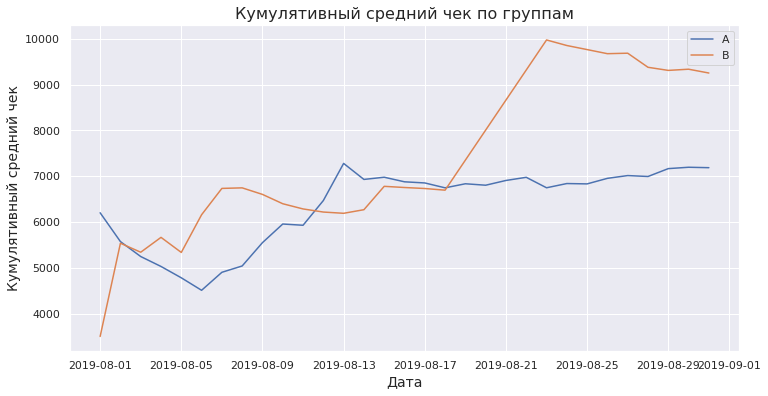

In [22]:
test_res_agg_A['cum_avg_check'] = test_res_agg_A['cum_revenue'] / test_res_agg_A['cum_orders']
test_res_agg_B['cum_avg_check'] = test_res_agg_B['cum_revenue'] / test_res_agg_B['cum_orders']
test_res_agg_B2 = test_res_agg_B.query('cum_avg_check < 10000')

plt.figure(figsize=(12,6))
sns.lineplot(data=test_res_agg_A, x='date', y='cum_avg_check', label='A')
sns.lineplot(data=test_res_agg_B2, x='date', y='cum_avg_check', label='B')

plt.xlabel('Дата', fontsize=14)
plt.ylabel('Кумулятивный средний чек', fontsize=14)
plt.title('Кумулятивный средний чек по группам', fontsize=16)

Мы построили график кумулятивного среднего чека без выбросов (срезали данные среднего чего до 10К рублей), видим, что  средний чек группы А все равно меньше

### График относительного изменения кумулятивного среднего чека группы B к группе A

Text(0.5, 1.0, 'Относительное изменение кумулятивного среднего чека')

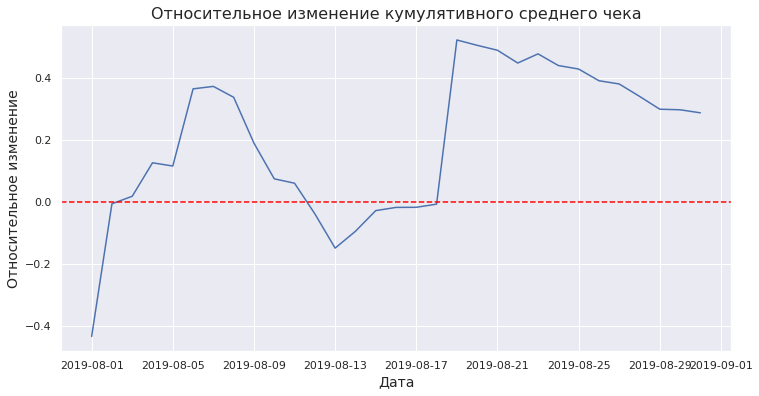

In [23]:
# построим график относительного различия для среднего чека
plt.figure(figsize=(12,6))

plt.plot(test_res_agg_A['date'], test_res_agg_B['cum_avg_check']/test_res_agg_A['cum_avg_check']-1)
plt.axhline(y=0, linestyle='--', color='red')

plt.xlabel('Дата', fontsize=14)
plt.ylabel('Относительное изменение', fontsize=14)
plt.title('Относительное изменение кумулятивного среднего чека', fontsize=16)

Группа Б на графике относительного изменения кумулятивного среднего чека не стабино лучше группы А, есть большой провал и резский всплеск, после чего плавное снижение. Не равномерный рост графика скорее всего связан с выбросом 19 августа.

### График кумулятивной конверсии по группам

Text(0.5, 1.0, 'Кумулятивная конверсия по группам')

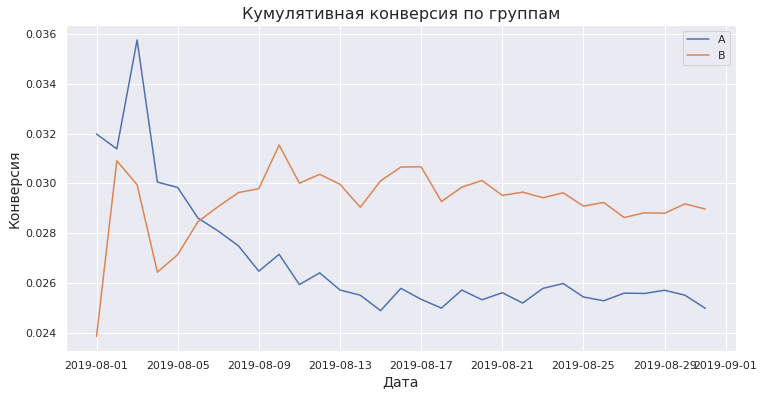

In [24]:
# рассчитаем для групп значение кумулятивной конверсии и построим графики
test_res_agg_A['cum_conversion'] = test_res_agg_A['cum_orders'] / test_res_agg_A['cum_visitors']
test_res_agg_B['cum_conversion'] = test_res_agg_B['cum_orders'] / test_res_agg_B['cum_visitors']

plt.figure(figsize=(12,6))
sns.lineplot(data=test_res_agg_A, x='date', y='cum_conversion', label='A')
sns.lineplot(data=test_res_agg_B, x='date', y='cum_conversion', label='B')

plt.xlabel('Дата', fontsize=14)
plt.ylabel('Конверсия', fontsize=14)
plt.title('Кумулятивная конверсия по группам', fontsize=16)

Конверсия группы А после резкого скачка до 3,6% начала сначало резко, а потом равномерно уменьшаться, просела до 2,5%
Во время снижении конверсии А, конверсия Б начала резко расти. Примерно на 10 день теста конверсии зафиксировались и до конца теста немного колебались около этой отметки. Б - 2,9%; А - 2,5%

### График относительного изменения кумулятивной конверсии группы B к группе A

Text(0.5, 1.0, 'Относительное изменение кумулятивной конверсии')

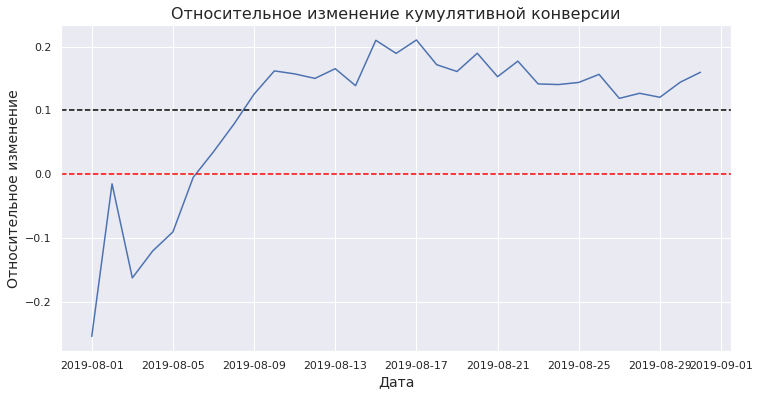

In [25]:
plt.figure(figsize=(12,6))

plt.plot(test_res_agg_A['date'], test_res_agg_B['cum_conversion']/test_res_agg_A['cum_conversion']-1)
plt.axhline(y=0, linestyle='--', color='red')
plt.axhline(y=0.1, linestyle='--', color='black')

plt.xlabel('Дата', fontsize=14)
plt.ylabel('Относительное изменение', fontsize=14)
plt.title('Относительное изменение кумулятивной конверсии', fontsize=16)

Значение кумулятивной конверсии по группе B стабильно возрастает по отношению к группе A с 3 по 10 августа, дальше наблюдаются колебания. Тем не менее, на протяжении всего периода с 6-го августа кумулятивное значение конверсии по группе B превышает значения по группе A. Со временем разрыв немного сокращается, однако в последние дни периода снова начинает расти.

### Точечный график количества заказов по пользователям

In [26]:
# рассчитаем количество заказов, совершённых каждым пользователем
orders_by_users = orders.drop(['group', 'revenue', 'date'], axis=1).\
groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})

orders_by_users.columns = ['visitor_id','orders']

orders_by_users.sort_values(by='orders',ascending=False).head(10)

,visitor_id,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


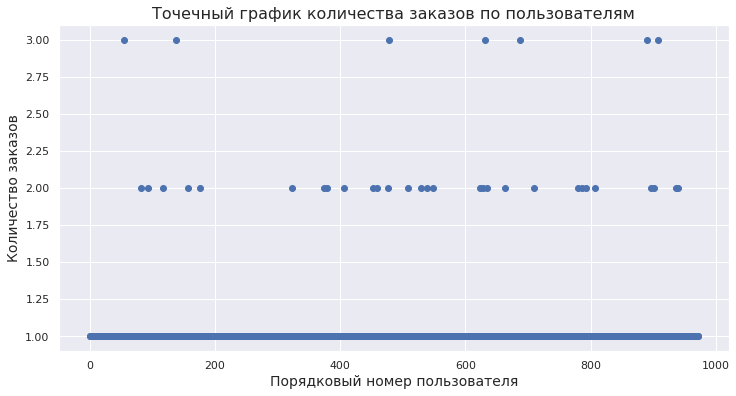

In [27]:
x_values = pd.Series(range(0,len(orders_by_users)))

plt.figure(figsize=(12,6))
plt.scatter(x_values, orders_by_users['orders'])
plt.xlabel('Порядковый номер пользователя', fontsize=14)
plt.ylabel('Количество заказов', fontsize=14)
plt.title('Точечный график количества заказов по пользователям', fontsize=16)
plt.show()

На графике видно, что большинство пользователей совершают 1-2 заказа. Однако, есть и те, которые совершают более 6 заказов. Есть и несколько выбросов, возможно в будущем можно будет ограничеть количество заказов для более точного анализа

### Расчёт 95-го и 99-го перцентилей количества заказов на пользователя, выбор границы для определения аномальных пользователей

In [28]:
np.percentile(orders_by_users['orders'], [95, 99])

array([1., 2.])

Таким образом, получается, что не более 5% пользователей совершают более 2-х заказов, и лишь 1% пользователей совершают более 4-х заказов, возможно можно это взять за границу числа заказов

### Точечный график стоимостей заказов

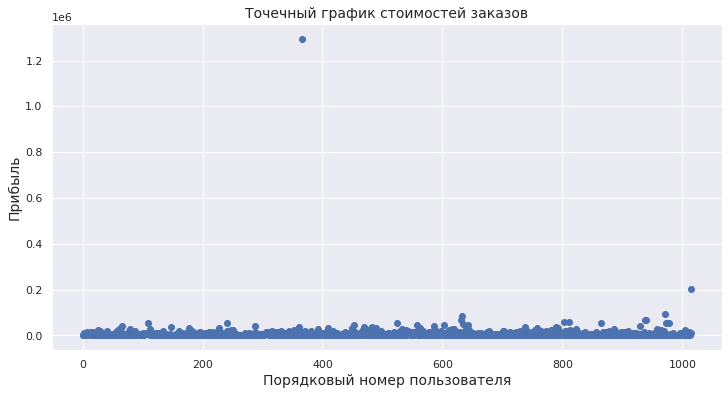

In [29]:
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.figure(figsize=(12,6))

plt.scatter(x_values, orders['revenue'])
plt.xlabel('Порядковый номер пользователя', fontsize=14)
plt.ylabel('Прибыль', fontsize=14)
plt.title('Точечный график стоимостей заказов', fontsize=14)
plt.show()

На графике видно два сильных выброса, которые мешают просмотреть более детальную картину и сжимают график

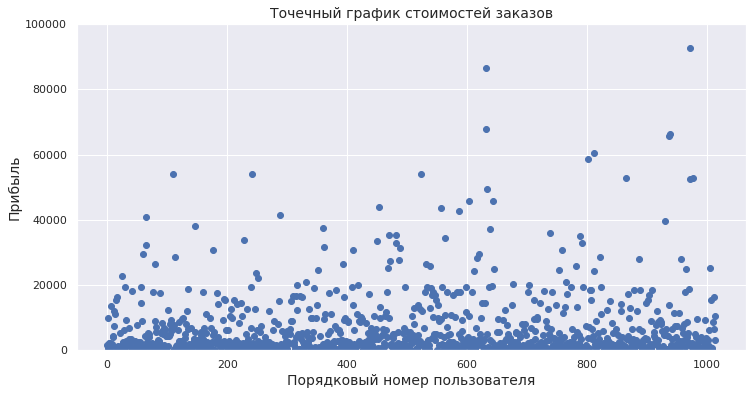

In [30]:

plt.figure(figsize=(12,6))

plt.scatter(x_values, orders['revenue'])
plt.xlabel('Порядковый номер пользователя', fontsize=14)
plt.ylabel('Прибыль', fontsize=14)
plt.ylim(0, 100000)
plt.title('Точечный график стоимостей заказов', fontsize=14)
plt.show()

На данном графике более наглядно видно, что большинство заказов не превосходит по стоимости 40 000. Однако, существуют и те, стоимость которых существенно выше. Далее необходимо будет определить границу для таких выбросов.

### Расчёт 95-го и 99-го перцентилей стоимости заказов, выбор границы для определения аномальных заказов

In [31]:
np.percentile(orders['revenue'], [95, 99])

array([26785., 53904.])

Не более 5% заказов осуществляются на сумму более 28 000. Лишь 1% заказов по стоимости превосходит порядка 58 000

In [32]:
# обозначим границы аномалий:
orders_board = int(np.percentile(orders_by_users['orders'], [99]))
revenue_board = int(np.percentile(orders['revenue'], [95]))

In [33]:
#отсеим аномальные заказы
orders.query('group == "B" & revenue > @revenue_board').groupby('date')['revenue'].sum().sort_values(ascending=False).head()

date
2019-08-19    1327905
2019-08-15     202740
2019-08-07     117953
2019-08-30     114720
2019-08-06      95689
Name: revenue, dtype: int64

### Pасчёт статистической значимости различий в конверсии между группами по «сырым» данным

H0: Средняя конверсия пользователей группы А равна средней конверсии пользователей группы B

H1: Средняя конверсия пользователей группы A отличается от средней конверсии пользователей группы B.

In [34]:

orders_by_users_a = orders[orders['group']=='A'].groupby('visitor_id', as_index=False).\
agg({'transaction_id' : pd.Series.nunique})
orders_by_users_a.columns = ['visitor_id', 'orders']

# определяем число заказов для каждого пользователя из группы B
orders_by_users_b = orders[orders['group']=='B'].groupby('visitor_id', as_index=False).\
agg({'transaction_id' : pd.Series.nunique})
orders_by_users_b.columns = ['visitor_id', 'orders']

# формируем выборку для группы A, посетителям, которые не совершили заказ будет соответствовать 0
sample_a = pd.concat([orders_by_users_a['orders'], pd.Series(0, index=np.arange(visitors.query('group == "A"')\
                    ['visitors'].sum() - len(orders_by_users_a['orders'])), name='orders')],axis=0)

# формируем выборку для группы B, посетителям, которые не совершили заказ будет соответствовать 0
sample_b = pd.concat([orders_by_users_b['orders'], pd.Series(0, index=np.arange(visitors.query('group == "B"')\
                    ['visitors'].sum() - len(orders_by_users_b['orders'])), name='orders')],axis=0)

# критический уровень статистической значимости
alpha = .05 

results = st.mannwhitneyu(sample_a, sample_b)

print('p-значение: ', "{0:.3f}".format(results.pvalue))

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")

print('Относительный прирост конверсии группы B:', "{0:.3f}".format(sample_b.mean()/sample_a.mean()-1))

p-значение:  0.011
Отвергаем нулевую гипотезу: разница статистически значима
Относительный прирост конверсии группы B: 0.160


прирост конверсии группы B составил почти 14%, и эта разница статистически значима. То есть по данному параметру можно говорить о том, что был достигнут рост конверсии.

### Расчёт статистической значимости различий в среднем чеке заказа между группами по «сырым» данным

In [35]:
# формируем выборку для группы A
sample_a_new = orders[orders['group']=='A']['revenue']

# формируем выборку для группы B
sample_b_new = orders[orders['group']=='B']['revenue']

# критический уровень статистической значимости
alpha = .05 

results = st.mannwhitneyu(sample_a_new, sample_b_new)

print('p-значение: ', "{0:.3f}".format(results.pvalue))

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")

print('Относительный прирост среднего чека группы B:', "{0:.3f}".format(sample_b_new.mean()/sample_a_new.mean()-1))

p-значение:  0.829
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя
Относительный прирост среднего чека группы B: 0.287


Xотя прирост среднего чека группы B составил почти 26%, эта разница статистически незначима. То есть по данному параметру нельзя говорить о том, что был достигнут значимый рост среднего чека.

### Расчёт статистической значимости различий в конверсии между группами по «очищенным» данным

Будем считать, что аномальными пользователями считаются пользователи совершившие больше 4 заказов или более 30К рублей.

In [36]:
# определим аномальных пользователей:

# более 4 заказов:
users_with_many_orders = pd.concat([orders_by_users_a[orders_by_users_a['orders'] > orders_board]['visitor_id'], \
                                    orders_by_users_b[orders_by_users_b['orders'] > orders_board]['visitor_id']], axis = 0)
# сумма более 30К
users_with_expensive_orders = orders[orders['revenue'] > revenue_board]['visitor_id']

abnormal_users = pd.concat([users_with_many_orders, users_with_expensive_orders], axis = 0).drop_duplicates().\
sort_values()

print(abnormal_users.shape[0])

58


58 пользователей - это в порядке 4-5% выборки

In [37]:
sample_a_filtered = pd.concat([orders_by_users_a[np.logical_not(orders_by_users_a['visitor_id'].\
                            isin(abnormal_users))]['orders'],pd.Series(0, index=np.arange(visitors.\
                            query('group == "A"')['visitors'].sum() - len(orders_by_users_a['orders'])),\
                                                                       name='orders')],axis=0)

# формируем выборку для группы B, исключая аномальных пользователей
sample_b_filtered = pd.concat([orders_by_users_b[np.logical_not(orders_by_users_b['visitor_id'].\
                            isin(abnormal_users))]['orders'],pd.Series(0, index=np.arange(visitors.\
                            query('group == "B"')['visitors'].sum() - len(orders_by_users_b['orders'])),\
                                                                       name='orders')],axis=0)

# критический уровень статистической значимости
alpha = .05 

results = st.mannwhitneyu(sample_a_filtered, sample_b_filtered)

print('p-значение: ', "{0:.3f}".format(results.pvalue))

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")

print('Относительный прирост конверсии группы B:', "{0:.3f}".format(sample_b_filtered.mean()/\
                                                                    sample_a_filtered.mean()-1))

p-значение:  0.012
Отвергаем нулевую гипотезу: разница статистически значима
Относительный прирост конверсии группы B: 0.182


По конверсии получаем практически такой же результат, как и для "сырых" данных. Таким образом, и по "сырым", и по "очищенным" данным можно говорить о росте конверсии примерно на 14%.

### Расчёт статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным

In [38]:
# формируем выборку для группы A, исключая аномальных пользователей
sample_a_new_filtered = orders[np.logical_and(orders['group']=='A', np.logical_not(orders['visitor_id'].\
                            isin(abnormal_users)))]['revenue']

# формируем выборку для группы B, исключая аномальных пользователей
sample_b_new_filtered = orders[np.logical_and(orders['group']=='B', np.logical_not(orders['visitor_id'].\
                            isin(abnormal_users)))]['revenue']

# критический уровень статистической значимости
alpha = .05 

results = st.mannwhitneyu(sample_a_new_filtered, sample_b_new_filtered)

print('p-значение: ', "{0:.3f}".format(results.pvalue))

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")

print('Относительный прирост среднего чека группы B:', "{0:.3f}".\
      format(sample_b_new_filtered.mean()/sample_a_new_filtered.mean()-1))

p-значение:  0.646
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя
Относительный прирост среднего чека группы B: -0.048


В данном случае также получаем, что как и по "сырым" данным, нельзя сделать вывод о различии. Однако, расчёт относительного изменения среднего чека кардинально изменился. Если по "сырым" данным получался рост почти на 26%, то по очищенным данным получаем сокращение среднего чека почти на 2%. Таким образом, можно говорить о том, что в группу Б попали аномальные пользователи с очень высокой стоимостью покупок.

## Принятие решений по результатам теста

Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий. Можно говорить о росте конверсии на 14%.

По сырым и отфильтрованным данным нет статистически значимого различия по среднему чеку между группами. Хотя аномальные пользователи оказали большое влияние на расчёт относительного изменения среднего чека.

График различия конверсии между группами сообщает, что результаты группы B лучше группы A: имеют тенденцию к росту, зафиксировались к концу периода на уровне 0.10 - 0.15.

График различия среднего чека колеблется, что позволило определить аномалии, определённого вывода по нему сделать нельзя.

На основе полученных выводов, я считаю, что можно остановить тест, зафиксировать победу группы B. Так как по среднему чеку статистически значимого падения по группе B не получили, зато увеличили конверсию, полагаю, это уже достаточно хороший результат.

## Общий вывод

При сортировке таблицы по ICE, на первое место выходит гипотеза №8. А при сортировке таблицы по RICE, на первое место выходит гипотеза №7.

Отличие в том, что фреймворк RICE в отличие от ICE учитывает охват пользователей. Гипотеза № 7 имеет 10 баллов из 10 по графе "reach" - охват пользователей. Наименее приоритетной при использовании обоих фреймворков является гипотеза № 4.

По результатам проведения A/B теста было выявлено следующее:

В данных присутствуют аномальные значения по числу заказов, совершённых одним пользователем, а также по стоимости заказа. Типичный пользователь совершает не более 4-х заказов на суммы, не превышающие 30 000. Самые крупные заказы с аномальной стоимостью приходятся на 19 августа.

Был достигнут статистически значимый рост конверсии по группе B (порядка 14% относительно группы A). К концу анализируемого периода конверсия по группе B колеблется на уровне 0.10 - 0.15.

Статистически значимое изменение среднего чека получено не было, даже при исключении аномальных заказов из расчёта. Однако, отмечено, что при исключении аномальных пользоватлей, получаем совершенно иной результат по относительному изменению среднего чека.

Так как по одному из параметров (конверсии) был достигнут хороший результат в результате внедрения изменения, а по второму не получили статистически значимого снижения, то результат теста признаю положительным, фиксируя победу группы B.